In [1]:
%load_ext autoreload
%autoreload 2

from style_transfer import *
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import CocoStuffDataSet

In [39]:
HEIGHT = WIDTH = 256
val_dataset = CocoStuffDataSet(mode='val', supercategories=['animal'], height=HEIGHT, width=WIDTH, do_normalize=False)


loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
Loaded 1016 samples: 


In [3]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
cnn = torchvision.models.vgg16(pretrained=True).features
cnn.cuda()
# cnn.type(dtype)
# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False
style_layers = (0, 5, 10, 17, 24)


In [4]:
def get_style_weights(beta):
    style_weights = np.array([100, 100, 10, 10, 1])
    return [float(x) for x in beta*style_weights]


In [5]:
def get_savename(content_idx, style_background, style_foreground=None, ground_truth=True):
    if ground_truth:
        name = "ground_truth_"
    else:
        name = "generated_"
    name += "{}_{}".format(content_idx, style_background.split('.')[0])
    if style_foreground:
        name += "_and_{}".format(style_foreground.split('.')[0])
    name += ".png"
    return name

In [13]:
def get_images_and_masks(load_folder):
    """
    Return a list of (image, ground truth mask, generated mask)
    for use in style transfer from input load_folder
    Assumes directory structure:
    code/
        /saved_images_and_masks
            /<load_folder>
                /img.pk
                /gt_mask.pk
                /gen_mask.pk
    """
    load_dir = os.path.join('./saved_images_and_masks', load_folder)
    img = torch.load(os.path.join(load_dir, 'img.pk'))
    img = PIL.Image.fromarray(np.uint8(img.numpy().transpose(1, 2, 0)*255.))
    gt_mask = torch.load(os.path.join(load_dir, 'gt_mask.pk'))
    gen_mask = torch.load(os.path.join(load_dir, 'gen_mask.pk'))
    return img, gt_mask, gen_mask    

In [54]:
alpha = 5e-4
beta = 1e3
gamma = 2e-2
savedir = './saved_style_transfers'
if not os.path.exists(savedir):
    os.makedirs(savedir)
style_dir = '../styles/'


Iteration 0,	Loss: 214817.34375,	Content: 0.0,	Style: 214700.96875,	TV: 116.36996459960938
Iteration 100,	Loss: 22711.708984375,	Content: 9981.6962890625,	Style: 11374.73046875,	TV: 1355.2835693359375
Iteration 200,	Loss: 18851.71875,	Content: 9260.314453125,	Style: 8207.046875,	TV: 1384.3572998046875
Iteration 300,	Loss: 17419.197265625,	Content: 8905.55859375,	Style: 7115.9609375,	TV: 1397.678466796875
Iteration 400,	Loss: 16681.0234375,	Content: 8703.375,	Style: 6566.79638671875,	TV: 1410.851806640625
Iteration 500,	Loss: 16233.064453125,	Content: 8575.7734375,	Style: 6238.33984375,	TV: 1418.951171875
Iteration 600,	Loss: 15901.322265625,	Content: 8480.943359375,	Style: 5993.5888671875,	TV: 1426.7899169921875
Iteration 700,	Loss: 15641.6435546875,	Content: 8400.626953125,	Style: 5807.3876953125,	TV: 1433.628662109375
Iteration 800,	Loss: 15443.0703125,	Content: 8328.08984375,	Style: 5674.73486328125,	TV: 1440.24609375
Iteration 900,	Loss: 15314.4970703125,	Content: 8281.482421875,	S

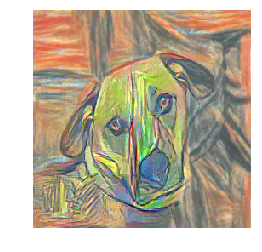

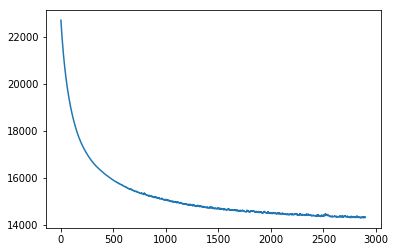

Iteration 0,	Loss: 242083.171875,	Content: 0.0,	Style: 241527.28125,	TV: 555.885986328125
Iteration 100,	Loss: 30511.2734375,	Content: 11567.8974609375,	Style: 17368.640625,	TV: 1574.734619140625
Iteration 200,	Loss: 25239.279296875,	Content: 10999.6416015625,	Style: 12615.8203125,	TV: 1623.818359375
Iteration 300,	Loss: 23189.755859375,	Content: 10671.0068359375,	Style: 10876.837890625,	TV: 1641.911376953125
Iteration 400,	Loss: 22038.65625,	Content: 10462.099609375,	Style: 9926.7265625,	TV: 1649.83056640625
Iteration 500,	Loss: 21273.328125,	Content: 10307.7509765625,	Style: 9309.994140625,	TV: 1655.5821533203125
Iteration 600,	Loss: 20732.498046875,	Content: 10193.8515625,	Style: 8879.365234375,	TV: 1659.28173828125
Iteration 700,	Loss: 20322.556640625,	Content: 10105.771484375,	Style: 8555.7578125,	TV: 1661.02685546875
Iteration 800,	Loss: 19981.427734375,	Content: 10028.900390625,	Style: 8290.6865234375,	TV: 1661.8424072265625
Iteration 900,	Loss: 19713.271484375,	Content: 9963.15

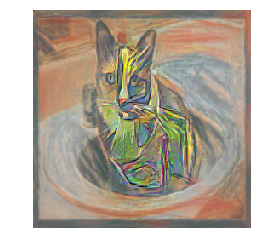

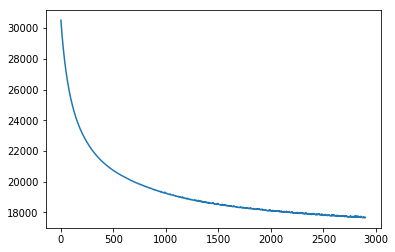

Iteration 0,	Loss: 187727.796875,	Content: 0.0,	Style: 186543.046875,	TV: 1184.7474365234375
Iteration 100,	Loss: 23296.185546875,	Content: 9173.9150390625,	Style: 12340.15625,	TV: 1782.1146240234375
Iteration 200,	Loss: 19356.0859375,	Content: 8758.7900390625,	Style: 8932.689453125,	TV: 1664.6055908203125
Iteration 300,	Loss: 17935.62890625,	Content: 8521.763671875,	Style: 7797.1572265625,	TV: 1616.708984375
Iteration 400,	Loss: 17184.75390625,	Content: 8384.6435546875,	Style: 7208.44482421875,	TV: 1591.6668701171875
Iteration 500,	Loss: 16703.7578125,	Content: 8288.5107421875,	Style: 6837.6806640625,	TV: 1577.566162109375
Iteration 600,	Loss: 16366.275390625,	Content: 8219.8720703125,	Style: 6579.19287109375,	TV: 1567.2109375
Iteration 700,	Loss: 16113.4453125,	Content: 8176.16845703125,	Style: 6376.8779296875,	TV: 1560.39794921875
Iteration 800,	Loss: 15921.2802734375,	Content: 8138.4541015625,	Style: 6227.8173828125,	TV: 1555.0086669921875
Iteration 900,	Loss: 15762.73046875,	Conte

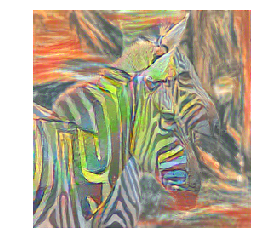

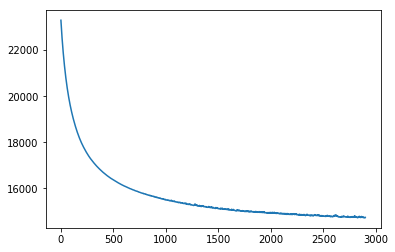

Iteration 0,	Loss: 140255.859375,	Content: 0.0,	Style: 140139.484375,	TV: 116.36996459960938
Iteration 100,	Loss: 14803.833984375,	Content: 6234.1767578125,	Style: 7799.640625,	TV: 770.01708984375
Iteration 200,	Loss: 12283.9814453125,	Content: 5874.498046875,	Style: 5608.98583984375,	TV: 800.4967041015625
Iteration 300,	Loss: 11323.4443359375,	Content: 5704.41162109375,	Style: 4797.66357421875,	TV: 821.3694458007812
Iteration 400,	Loss: 10812.83203125,	Content: 5605.58935546875,	Style: 4374.14404296875,	TV: 833.0982666015625
Iteration 500,	Loss: 10516.955078125,	Content: 5502.443359375,	Style: 4173.22265625,	TV: 841.2886352539062
Iteration 600,	Loss: 10272.3173828125,	Content: 5452.201171875,	Style: 3973.01806640625,	TV: 847.0990600585938
Iteration 700,	Loss: 10097.79296875,	Content: 5424.69287109375,	Style: 3821.018310546875,	TV: 852.0823974609375
Iteration 800,	Loss: 9971.6083984375,	Content: 5434.68212890625,	Style: 3681.2548828125,	TV: 855.6708984375
Iteration 900,	Loss: 9839.3193

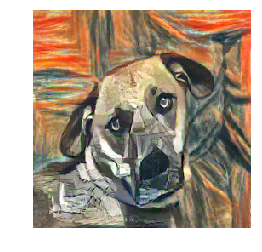

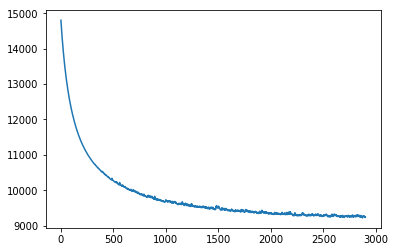

Iteration 0,	Loss: 166383.296875,	Content: 0.0,	Style: 165827.40625,	TV: 555.885986328125
Iteration 100,	Loss: 19404.021484375,	Content: 7253.44873046875,	Style: 11156.830078125,	TV: 993.7420043945312
Iteration 200,	Loss: 16074.2998046875,	Content: 6954.37353515625,	Style: 8095.953125,	TV: 1023.9735107421875
Iteration 300,	Loss: 14763.638671875,	Content: 6799.662109375,	Style: 6927.4482421875,	TV: 1036.5281982421875
Iteration 400,	Loss: 14012.8759765625,	Content: 6702.1416015625,	Style: 6271.07470703125,	TV: 1039.6593017578125
Iteration 500,	Loss: 13500.2421875,	Content: 6637.12109375,	Style: 5826.9794921875,	TV: 1036.1412353515625
Iteration 600,	Loss: 13120.169921875,	Content: 6576.24169921875,	Style: 5511.00146484375,	TV: 1032.927001953125
Iteration 700,	Loss: 12825.1474609375,	Content: 6520.4208984375,	Style: 5276.2822265625,	TV: 1028.4447021484375
Iteration 800,	Loss: 12606.119140625,	Content: 6501.69873046875,	Style: 5079.0888671875,	TV: 1025.33251953125


KeyboardInterrupt: 

In [55]:
backgrounds = ['the_scream.jpg', 'starry_night.jpg', 'tsunami.jpg']
foregrounds = ['muse.jpg', 'guernica.jpg', 'guitar.jpg']
background_images = [PIL.Image.open(os.path.join(style_dir, n)) for n in backgrounds]
foreground_images = [PIL.Image.open(os.path.join(style_dir, n)) for n in foregrounds]
for style_background_name in backgrounds:
    for style_foreground_name in foregrounds:
        # suggested indices: 417, 77, 55
        style_background_image = PIL.Image.open(os.path.join(style_dir, style_background_name))
        style_foreground_image = PIL.Image.open(os.path.join(style_dir, style_foreground_name))
        for idx in (417, 77, 55):
#             content_image, background_mask = get_image_from_dataset(val_dataset, idx)
            content_image, background_mask, generated_background_mask = get_images_and_masks(str(idx))
            img, mask = get_image_from_dataset(val_dataset, idx)
            
            savename = get_savename(idx, style_background_name, style_foreground_name, ground_truth=True)
            savepath = os.path.join(savedir, savename)
            transfer_params = {
                'cnn' : cnn,
                'content_image' : content_image,
                'style_image' : style_background_image,
                'content_mask': background_mask,
                'image_size' : HEIGHT,
                'content_layer' : 12,
                'content_weight' : alpha,
                'style_layers' : style_layers,
                'style_weights' : get_style_weights(beta),
                'tv_weight' : gamma,
                'max_iters' : 3000,
                'init_random' : False,
                'mask_layer' : True,
                'second_style_image' : style_foreground_image 
            }

            final_img, final_loss, loss_list = style_transfer(**transfer_params)
            display_style_transfer(final_img, savepath)
#             loss_list = loss_list[100:]
#             plt.plot(range(len(loss_list)), loss_list)
#             plt.show()
            
#             savename = get_savename(idx, style_background_name, style_foreground_name, ground_truth=False)
#             savepath = os.path.join(savedir, savename)
#             transfer_params['content_mask'] = generated_background_mask
#             final_img, final_loss = style_transfer(**transfer_params)
#             display_style_transfer(final_img, savepath)